# P2 Milestone: Predictig the present

In [41]:

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_absolute_error
import warnings

warnings.filterwarnings("ignore") # While fitting AR model we obtain warnings to ignore

## Loading data

<AxesSubplot:xlabel='Period'>

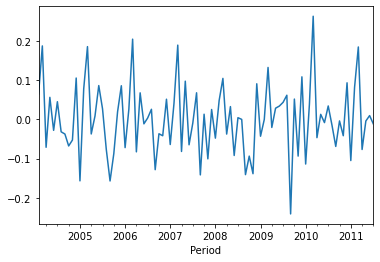

In [154]:
# Loading and processing data
df=pd.read_csv(r".\merged_autos.csv")
df['Period'] = pd.to_datetime(df['Period'])
df.set_index('Period',inplace=True)
df['sales'] = np.log(df['sales'])-np.log(df['sales'].shift(1))
# df['sales_stat']=(df['sales']-df['sales'].shift(1))
# df['sales_stat']=df['sales']
df.dropna(inplace=True)
df['sales'].plot()

In [162]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.loc[df.index>='01-01-2007','sales'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.923269
p-value: 0.780213


### We fail reject the null hypthesis (non stationarity)

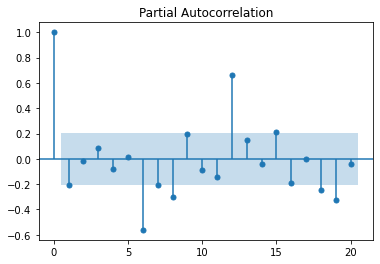

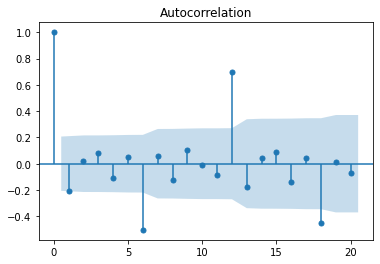

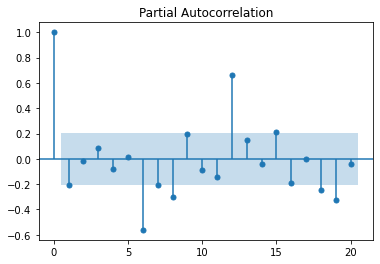

In [146]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df['sales'])
plot_pacf(df['sales'], lags=20)

### We can see that from ACF and PACF that an ARMA model can be built to better model the data. We have to be aware that the timeserie is not stationary hence a rolling method is necessary to obtain the right parameters

## Overall AR model fit

### Overall Base model

The base model is an AR model with Lags 1 and 12.
The AutoReg package is used to fit the model

In [3]:
#Fitting base line model with lag 1 and Lag 12
AR_endo = AutoReg(endog=df['sales'], lags=[1,12]).fit()
AR_endo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  sales   No. Observations:                   91
Model:             Restr. AutoReg(12)   Log Likelihood                  89.115
Method:               Conditional MLE   S.D. of innovations              0.078
Date:                Fri, 06 Nov 2020   AIC                             -4.993
Time:                        16:24:31   BIC                             -4.873
Sample:                    01-01-2005   HQIC                            -4.945
                         - 07-01-2011                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6727      0.749      0.898      0.369      -0.795       2.141
sales.L1       0.6435      0.072      8.948      0.000       0.503       0.784
sales.L12      0.2957      0.071      4.139      0.000       0.156       0.436
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0136           -0.0000j            1.0136           -0.0000
AR.2             0.9322           -0.4728j            1.0452           -0.0747
AR.3             0.9322           +0.4728j            1.0452            0.0747
AR.4             0.6048           -0.9087j            1.0915           -0.1565
AR.5             0.6048           +0.9087j            1.0915            0.1565
AR.6             0.0603           -1.1224j            1.1240           -0.2415
AR.7             0.0603           +1.1224j            1.1240            0.2415
AR.8            -0.5346           -1.0120j            1.1445           -0.3273
AR.9            -0.5346           +1.0120j            1.1445            0.3273
AR.10           -1.1595           -0.0000j            1.1595           -0.5000
AR.11           -0.9897           -0.5971j            1.1559           -0.4136
AR.12           -0.9897           +0.5971j            1.1559            0.4136
------------------------------------------------------------------------------
"""

<AxesSubplot:>

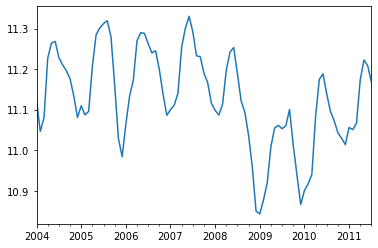

In [141]:
# AR_endo = AutoReg(endog=df['sales'], lags=[1,2,3,4,5,6,7,8,9,10,11,12]).fit()
# AR_endo.summary()
ARMA_endo=ARMA(endog=df['sales'],order=(2,2)).fit()
ARMA_endo.summary()
ARMA_endo.predict().plot()

### We can see that several lags have statistically signicant coefficients. We are going to remove variables with pvalue>0.05. In the paper lag 12 was chosen but using different lags shows that there is redundance, hence using lag 12 while using other lags is not the best choice.

In [70]:
selected_lags=[1,3,4,6,7,9,10]
# selected_lags=[1,6,7]

AR_endo = AutoReg(endog=df['sales'], lags=selected_lags).fit()
AR_endo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  sales   No. Observations:                   91
Model:             Restr. AutoReg(10)   Log Likelihood                 106.320
Method:               Conditional MLE   S.D. of innovations              0.065
Date:                Sun, 13 Dec 2020   AIC                             -5.241
Time:                        11:59:48   BIC                             -4.975
Sample:                    11-01-2004   HQIC                            -5.134
                         - 07-01-2011                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8864      0.725      1.223      0.221      -0.535       2.307
sales.L1       0.7208      0.092      7.875      0.000       0.541       0.900
sales.L3       0.4391      0.110      3.984      0.000       0.223       0.655
sales.L4      -0.2716      0.116     -2.340      0.019      -0.499      -0.044
sales.L6      -0.6004      0.100     -5.986      0.000      -0.797      -0.404
sales.L7       0.4261      0.116      3.677      0.000       0.199       0.653
sales.L9       0.4253      0.114      3.746      0.000       0.203       0.648
sales.L10     -0.2192      0.108     -2.037      0.042      -0.430      -0.008
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -0.9373           -0.5083j            1.0663           -0.4209
AR.2            -0.9373           +0.5083j            1.0663            0.4209
AR.3            -0.5852           -1.0692j            1.2188           -0.3297
AR.4            -0.5852           +1.0692j            1.2188            0.3297
AR.5             0.0407           -1.0720j            1.0728           -0.2440
AR.6             0.0407           +1.0720j            1.0728            0.2440
AR.7             0.8930           -0.5388j            1.0429           -0.0864
AR.8             0.8930           +0.5388j            1.0429            0.0864
AR.9             1.0368           -0.0000j            1.0368           -0.0000
AR.10            2.0813           -0.0000j            2.0813           -0.0000
------------------------------------------------------------------------------
"""

In [104]:
# selected_lags=[1,3,6,7,9]
selected_lags=[1,2,3,12]

AR_endo = AutoReg(endog=df['sales'], lags=selected_lags).fit()
AR_endo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  sales   No. Observations:                   91
Model:             Restr. AutoReg(12)   Log Likelihood                  89.639
Method:               Conditional MLE   S.D. of innovations              0.078
Date:                Sun, 13 Dec 2020   AIC                             -4.955
Time:                        12:17:29   BIC                             -4.775
Sample:                    01-01-2005   HQIC                            -4.883
                         - 07-01-2011                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6162      0.785      0.785      0.432      -0.922       2.154
sales.L1       0.5841      0.106      5.507      0.000       0.376       0.792
sales.L2       0.1263      0.123      1.027      0.305      -0.115       0.367
sales.L3      -0.0572      0.101     -0.564      0.573      -0.256       0.142
sales.L12      0.2911      0.071      4.075      0.000       0.151       0.431
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0127           -0.0000j            1.0127           -0.0000
AR.2             0.9347           -0.4695j            1.0460           -0.0741
AR.3             0.9347           +0.4695j            1.0460            0.0741
AR.4             0.6129           -0.9129j            1.0995           -0.1559
AR.5             0.6129           +0.9129j            1.0995            0.1559
AR.6             0.0567           -1.1351j            1.1365           -0.2421
AR.7             0.0567           +1.1351j            1.1365            0.2421
AR.8            -1.1410           -0.0000j            1.1410           -0.5000
AR.9            -0.9895           -0.5792j            1.1465           -0.4157
AR.10           -0.9895           +0.5792j            1.1465            0.4157
AR.11           -0.5506           -1.0103j            1.1506           -0.3294
AR.12           -0.5506           +1.0103j            1.1506            0.3294
------------------------------------------------------------------------------
"""

### We obtain a model with Smaller BIC where all regressors are statsically significant

### Overall Trends model

The updated AR model contains exogenous data from google trends: suvs and insurance

In [93]:
# Fitting AR model with Trends data
AR_endo_exo = AutoReg(endog=df["sales"], lags=[1,12], exog=df[["suvs", "insurance"]]).fit()
AR_endo_exo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             AutoReg Model Results                              
================================================================================
Dep. Variable:                    sales   No. Observations:                   91
Model:             Restr. AutoReg-X(12)   Log Likelihood                 106.312
Method:                 Conditional MLE   S.D. of innovations              0.063
Date:                  Sun, 13 Dec 2020   AIC                             -5.377
Time:                          12:07:33   BIC                             -5.197
Sample:                      01-01-2005   HQIC                            -5.305
                           - 07-01-2011                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.4580      0.759     -0.603      0.546      -1.946       1.030
sales.L1       0.6195      0.061     10.131      0.000       0.500       0.739
sales.L12      0.4287      0.063      6.777      0.000       0.305       0.553
suvs           1.0572      0.161      6.546      0.000       0.741       1.374
insurance     -0.5297      0.147     -3.599      0.000      -0.818      -0.241
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.9913           -0.0000j            0.9913           -0.0000
AR.2             0.9045           -0.4654j            1.0172           -0.0756
AR.3             0.9045           +0.4654j            1.0172            0.0756
AR.4             0.5820           -0.8833j            1.0578           -0.1573
AR.5             0.5820           +0.8833j            1.0578            0.1573
AR.6             0.0551           -1.0864j            1.0878           -0.2419
AR.7             0.0551           +1.0864j            1.0878            0.2419
AR.8            -0.5189           -0.9780j            1.1071           -0.3276
AR.9            -0.5189           +0.9780j            1.1071            0.3276
AR.10           -1.1214           -0.0000j            1.1214           -0.5000
AR.11           -0.9577           -0.5766j            1.1179           -0.4137
AR.12           -0.9577           +0.5766j            1.1179            0.4137
------------------------------------------------------------------------------
"""

In [94]:
AR_endo_exo = AutoReg(endog=df["sales"], lags=selected_lags, exog=df[["suvs", "insurance"]]).fit()
AR_endo_exo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  sales   No. Observations:                   91
Model:                   AutoReg-X(1)   Log Likelihood                 102.476
Method:               Conditional MLE   S.D. of innovations              0.077
Date:                Sun, 13 Dec 2020   AIC                             -5.004
Time:                        12:07:43   BIC                             -4.865
Sample:                    02-01-2004   HQIC                            -4.948
                         - 07-01-2011                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.7272      0.741      3.680      0.000       1.275       4.180
sales.L1       0.7642      0.066     11.618      0.000       0.635       0.893
suvs           0.7192      0.178      4.043      0.000       0.371       1.068
insurance     -0.0747      0.134     -0.556      0.578      -0.338       0.189
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3086           +0.0000j            1.3086            0.0000
-----------------------------------------------------------------------------
"""

As we can, both the overall base and trends models result to exactly the same parameters shown in the paper.

## Rolling Out-of-sample model

In [138]:
#Adding shift for outsample rolling predictions calculations
from statsmodels.regression.rolling import RollingOLS
for i in np.arange(1,13,1):
    df['sales_'+str(i)]=df['sales'].shift(i)
df['intercept']=1

#Functions calculating rolling AR out_sample predictions
#Base Model
def rolling_AR_endo(df, window,lags=[1,12],ARMA_bool=False):
    results = []
    regressor_names=['intercept']+['sales_'+str(i) for i in lags]
#     regressor_names =  ['intercept','sales_1','sales_12']
    for i in np.arange(window,len(df)):
        df_training=df.iloc[0:i]
        outsample=df.iloc[i]
        if ARMA_bool:
            result_fit = ARMA(endog=df_training['sales'], order=(3,3)).fit()
            result_pred=result_fit.predict(start=len(df_training['sales']),end=len(df_training['sales']))[0]
        else:
            result_fit = AutoReg(endog=df_training['sales'], lags=lags).fit()
            result_pred = np.sum(np.array(result_fit.params)*np.array(outsample[regressor_names]))
        results.append(result_pred)
    return results
#Trends model
def rolling_AR_exo(df, window, lags=[1,12], exogenous_regressors=["suvs", "insurance"],ARMA_bool=False):
    results=[]
    regressor_names = ['intercept']+['sales_'+str(i) for i in lags] +exogenous_regressors
#     exogenous_regressors=["suvs", "insurance"]
    
    for i in np.arange(window, len(df)):
        df_training=df.iloc[0:i]
        outsample=df.iloc[i]
        if ARMA_bool:
            result_fit = ARMA(endog=df_training['sales'], order=(3,3),exog=df_training[exogenous_regressors]).fit()
            result_pred=result_fit.predict(start=len(df_training['sales']),end=len(df_training['sales']),exog=outsample[exogenous_regressors])[0]
        else:
            result_fit=AutoReg(endog=df_training['sales'], lags=lags, exog=df_training[exogenous_regressors]).fit()
            result_pred = np.sum(np.array(result_fit.params)*np.array(outsample[regressor_names]))
        results.append(result_pred)
    return results




In [132]:
#Outsample AutoReg for the base model
df.loc[df.index >= "2005-06-01",'Baseline_Predictions'] = rolling_AR_endo(df, 17)

#Autoreg cannot be fitted for the first iteration hence we use k=18 and replace the first prediction by the baseline
df.loc[df.index >= "2005-07-01",'Trends_Predictions'] = rolling_AR_exo(df, 18)
df.loc["2005-06-01",'Trends_Predictions']=df.loc["2005-06-01",'Baseline_Predictions']
#Keeping only the dates where we have predictions
df_results=df[df.index >= "2005-06-01"]

#Calculating MAE
baseline_mae = mean_absolute_error(df_results['sales'], df_results['Baseline_Predictions'])
trends_mae = mean_absolute_error(df_results['sales'], df_results['Trends_Predictions'])
improvement = (baseline_mae-trends_mae)/baseline_mae


print(f"MAE of the baseline model: {baseline_mae*100:.2f}%")
print(f"MAE of the trends model: {trends_mae*100:.2f}%")
print(f"MAE improvement: {improvement*100:.2f}%")



MAE of the baseline model: 6.34%
MAE of the trends model: 5.66%
MAE improvement: 10.76%


In [139]:
#Outsample AutoReg for the base model
df.loc[df.index >= "2005-06-01",'Baseline_Predictions'] = rolling_AR_endo(df,17,lags=selected_lags,ARMA_bool=True)

#Autoreg cannot be fitted for the first iteration hence we use k=18 and replace the first prediction by the baseline
df.loc[df.index >= "2005-07-01",'Trends_Predictions'] = rolling_AR_exo(df, 18, lags=selected_lags,ARMA_bool=True)
df.loc["2005-06-01",'Trends_Predictions']=df.loc["2005-06-01",'Baseline_Predictions']
#Keeping only the dates where we have predictions
df_results=df[df.index >= "2005-06-01"]

#Calculating MAE
baseline_mae = mean_absolute_error(df_results['sales'], df_results['Baseline_Predictions'])
trends_mae = mean_absolute_error(df_results['sales'], df_results['Trends_Predictions'])
improvement = (baseline_mae-trends_mae)/baseline_mae


print(f"MAE of the baseline model: {baseline_mae*100:.2f}%")
print(f"MAE of the trends model: {trends_mae*100:.2f}%")
print(f"MAE improvement: {improvement*100:.2f}%")


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [7]:
#keeping results only for recession period
df_results_recession = df_results.loc[(df_results.index >= "2007-12-01") & (df_results.index <= "2009-06-01")]

baseline_mae_recession = mean_absolute_error(df_results_recession['sales'], df_results_recession['Baseline_Predictions'])
trends_mae_recession = mean_absolute_error(df_results_recession['sales'], df_results_recession['Trends_Predictions'])
improvement_recession = (baseline_mae_recession-trends_mae_recession)/baseline_mae_recession

print(f"MAE of the baseline model during recession: {baseline_mae_recession*100:.2f}%")
print(f"MAE of the trends model during recession: {trends_mae_recession*100:.2f}%")
print(f"MAE improvement during recession: {improvement_recession*100:.1f}%")




MAE of the baseline model during recession: 8.87%
MAE of the trends model during recession: 6.97%
MAE improvement during recession: 21.5%


Text(0.02, 0.15, 'MAE improvement\nOverall = 10.8%\nDuring recession: 21.5%')

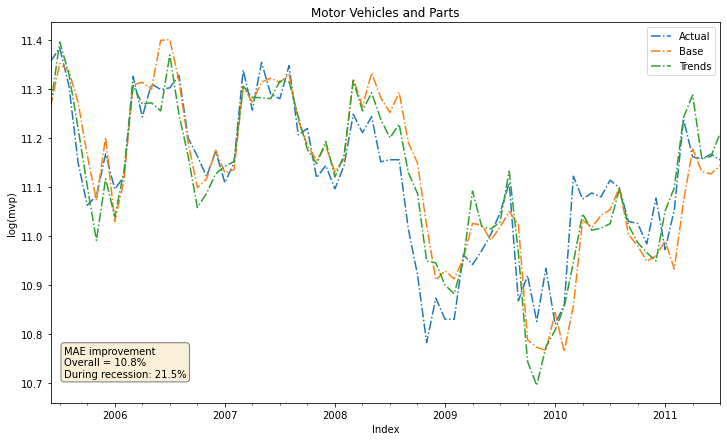

In [11]:
paper_names = {'sales':'Actual','Baseline_Predictions':'Base', 'Trends_Predictions':'Trends'}
df_results.rename(columns=paper_names,inplace=True)

ax = df_results[['Actual','Base','Trends']].plot(figsize=(12,7), 
                                                 ylabel="log(mvp)",xlabel="Index",title="Motor Vehicles and Parts", style='-.')

textstr = '\n'.join((
    "MAE improvement",
    f"Overall = {improvement*100:.1f}%",
    f"During recession: {improvement_recession*100:.1f}%"))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.02, 0.15, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)


## Conclusion

We were able to reproduce results that really close to he paper. The only difference resides when trying to fit out-of-sample Trends model. The AutoReg does not work for k=17 for the first iteration (too few datapoints to fit the model). We believe that the results are accurate and that the paper used a different package that allows fitting for k=17.